In [1]:
import sys

sys.path.append('..')

import torch
import matplotlib.pyplot as plt
import numpy as np 
import statsmodels.api as sm
import networkx as nx
import seaborn as sns
import pandas as pd

from spikeometric.models import BernoulliGLM
from spikeometric.datasets import NormalGenerator, ConnectivityDataset
from spikeometric.stimulus import RegularStimulus

from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj, to_networkx, from_networkx

from CD_methods import SCM_learner, observational_learner_Poisson, interventional_learner_Poisson
from functions import *

from tqdm import tqdm
from scipy.stats import chi2

### Testing function here

In [2]:
n_obs = 10
n_hidden = 10 

index_obs = np.sort(np.random.choice(n_obs+n_hidden, size = n_obs, replace = False))

n_networks = 1

# model parameters
theta = 3
mu = 0
sigma = 5

generator = NormalGenerator(
    n_neurons=n_obs + n_hidden,
    mean=mu,
    std=sigma,
    glorot=True,
    sparsity=0.5
)

# set up the neuron model
neuron_model = BernoulliGLM(
    theta=theta,
    dt=1.,
    coupling_window=3,
    abs_ref_scale=1,
    abs_ref_strength=-100,
    rel_ref_scale=2,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

network_data = generator.generate(n_networks)
example_network = network_data[0]
G = to_networkx(example_network)

example_network.W0[example_network.W0 > 0.0] = 1.5
example_network.W0[example_network.W0 < 0.0] = -3

# Notes:
- Observed can have more variable synaptic weights
- plot ISI, mål CV (skal helst være bred), noise correlations -- to check if spike distr. is realistic

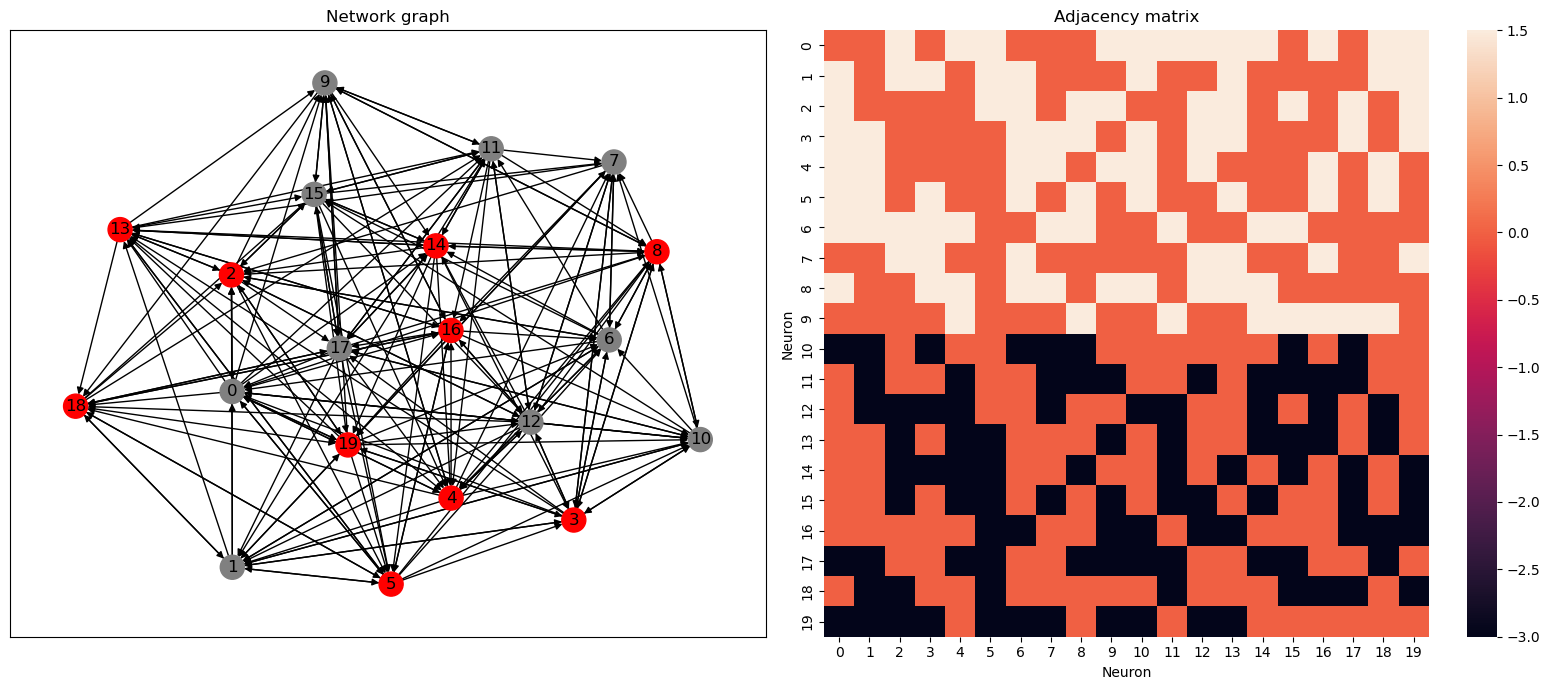

In [3]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
color_map = ['grey' if node not in index_obs else 'red' for node in G]        

nx.draw_networkx(G, arrows=True, ax=ax[0], node_color=color_map)
ax[0].set_title("Network graph")

W0 = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=example_network.num_nodes)[0]
sns.heatmap(W0, ax=ax[1], annot=False)
ax[1].set_title("Adjacency matrix")
ax[1].set_xlabel("Neuron")
ax[1].set_ylabel("Neuron")

plt.tight_layout()
plt.show()

In [4]:
prop_intervened = 1.0

spike_data = []
spike_data_dict = dict()
n_timesteps = 10**4

# complete single neuron stimulation protocol
stimulation_protocol = [[i] for i in index_obs]
stimulation_protocol_str = [str(i) for i in index_obs] + ['null']

stimulate_nodes = np.sort(np.random.choice(index_obs, size = int(n_obs*prop_intervened), replace = False))
stimulation_protocol = [[i] for i in stimulate_nodes]
stimulation_protocol_str = [str(i) for i in stimulate_nodes] + ['null']

print('Observed nodes', index_obs)
print(len(index_obs))
#print('stimulation_protocol_str', stimulation_protocol_str)

Observed nodes [ 2  3  4  5  8 13 14 16 18 19]
10


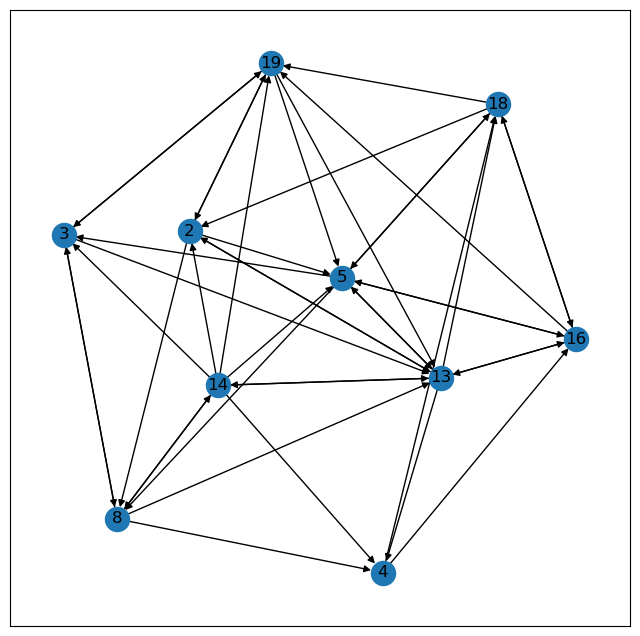

In [5]:
G_obs = nx.subgraph(G, index_obs)
plt.figure(figsize=(8,8))
nx.draw_networkx(G_obs, arrows=True)

In [6]:
for i, intervention in tqdm(enumerate(stimulation_protocol_str), total = len(stimulation_protocol_str)):

    # stimulate the observable neurons one by one
    stimulus_mask = torch.zeros(n_obs+n_hidden, dtype=torch.bool)
    
    if intervention != 'null':
        intervention_set = stimulation_protocol[i]
        stimulus_mask[intervention_set] = True
    
    #print('Simulating intervention on set ', intervention)
    
    neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
    spikes = neuron_model.simulate(example_network, n_steps=n_timesteps, verbose=False)
    
    spike_data_dict[intervention] = spikes[index_obs]

100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.63it/s]


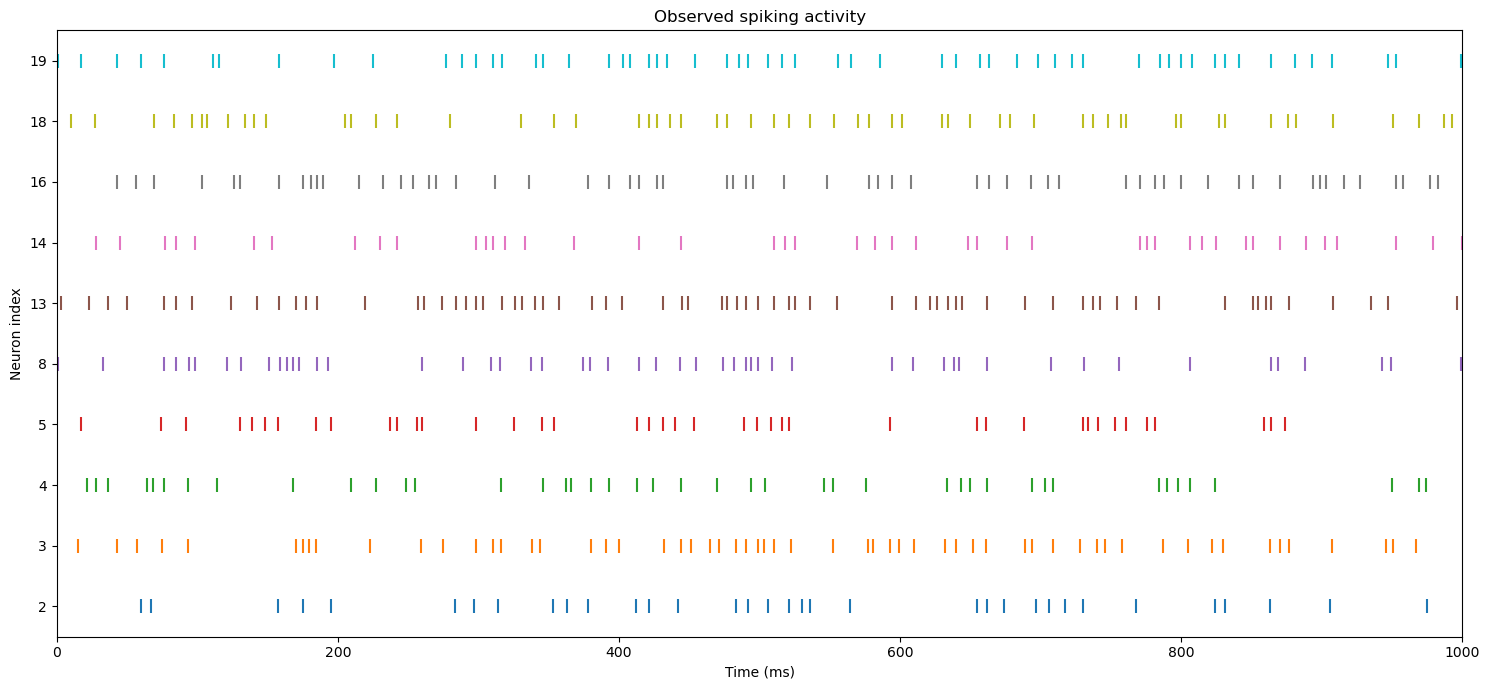

In [7]:
spikes = spike_data_dict['null']

plt.figure(figsize=(15,7))

for i in range(len(index_obs)):
    plt.scatter(np.where(spikes[i,:] == 1)[0], i*np.ones_like(np.where(spikes[i,:] == 1)[0]), marker='|', s=100)

plt.yticks(ticks=np.arange(len(index_obs)),labels=index_obs)
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.xlim([0, 1000])
plt.ylim([-0.5, n_obs - 0.5])
plt.title("Observed spiking activity")
plt.tight_layout()
plt.show()

In [9]:
G_learned_null = observational_learner_Poisson(
    spike_data_dict, 
    node_list=index_obs, 
    alpha = 1e-5)

In [10]:
G_true = nx.subgraph(G, index_obs)

SHD = compute_SHD(G_true, G_learned_null)
print('TP = ', count_true_positive(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
print('TN = ', count_true_negative(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
print('FP = ', count_false_positive(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
print('FN = ', count_false_negative(G_learned=G_learned_null, G_true=G_true,nodelist=index_obs))
print('SHD = ', SHD)

TP =  43
TN =  57
FP =  0
FN =  0
SHD =  0


In [31]:
G_learned = interventional_learner_Poisson(
    spike_data_dict, 
    node_list=list(index_obs), 
    SCM_learned=G_learned_null,
    stimulation_protocol=stimulation_protocol, 
    alpha = 1e-5)

 20%|████████▊                                   | 3/15 [00:05<00:19,  1.66s/it]

0 10 477.6491588866893 3.32815826317802e-103
6 10 191.7926684715335 2.502385503688022e-41
11 10 255.18541954275497 4.945955340872201e-55
14 10 203.79651681772657 6.379735157835126e-44
17 10 276.1789827281027 1.4210040778168645e-59


 27%|███████████▋                                | 4/15 [00:06<00:17,  1.56s/it]

20 10 24.470749318958042 1.9919429400788527e-05


100%|███████████████████████████████████████████| 15/15 [00:33<00:00,  2.24s/it]


In [32]:
SHD = compute_SHD(G_true, G_learned)
print('SHD = ', SHD)
print('TP = ', count_true_positive(G_learned=G_learned, G_true=G_true,nodelist=index_obs))
print('TN = ', count_true_negative(G_learned=G_learned, G_true=G_true,nodelist=index_obs))
print('FP = ', count_false_positive(G_learned=G_learned, G_true=G_true,nodelist=index_obs))
print('FN = ', count_false_negative(G_learned=G_learned, G_true=G_true,nodelist=index_obs))


SHD =  0
TP =  106
TN =  119
FP =  0
FN =  0


In [25]:
for edge in G_learned.edges():
    if edge not in G_true.edges():
        print(edge)

(10, 20)


### Notes
- For a network of 40 neurons, where 20 are observed, stimulating a randomly selected proportion of the observed nodes yields 
    - SHD(0%) = 15,
    - SHD(50%) = 10, 
    - SHD(60%) = 9,
    - SHD(70%) = 5,
    - SHD(80%) = 1,
    - SHD(100%) = 2.

What I an be explored further:
- Compare SHD of several networks (different connectivities, same num. observed and hidden nodes), where I vary the proportion of how many (single) nodes in the network are stimulated, too see how many singleton interventions are needed to correct for confounding effects.
- Look at multiple intervention protocols as well.
- Compare different algorithms and count number of needed interventions / intervention sets.

In [595]:
import pickle

results = {
    'spike_data' : spike_data_dict, 
    'G_true' : G, 
    'G_learned' : G_learned, 
    'nodes_observed' : index_obs,
    'stimulation_protocol' : stimulation_protocol
}

with open(f'data/results_{n_obs}_{n_hidden}_nodes.pickle','wb') as f:
        pickle.dump(results,f)  

In [540]:
10**4 / 10**3

10.0

In [73]:

def observational_learner_Poisson(
    spike_data, 
    node_list, 
    stimulation_protocol, 
    alpha=0.05):
    
    node_list = list(node_list)
    SCM_learned = nx.DiGraph()
    SCM_learned.add_nodes_from(np.sort(node_list))

    # observational data
    spikes = spike_data['null']
            
    for idx, neuron_id in enumerate(node_list):
        
        target_spikes = spikes[idx].numpy()
        
        source_spikes1 = np.delete(torch.roll(spikes, 1), idx, axis=0) # synaptic effect from 1 time step before
        source_spikes2 = np.delete(torch.roll(spikes, 2), idx, axis=0) # synaptic effect from 2 time step before
        source_spikes3 = np.delete(torch.roll(spikes, 3), idx, axis=0) # synaptic effect from 3 time step before

        autoregressive_feature1 = torch.roll(spikes[idx], 1).numpy() # 1 time step history effects
        autoregressive_feature2 = torch.roll(spikes[idx], 2).numpy() # 2 time step history effects
        autoregressive_feature3 = torch.roll(spikes[idx], 3).numpy() # 3 time step history effects

        # create design matrix
        X = np.vstack(
            (source_spikes1, 
             source_spikes2, 
             source_spikes3,
             autoregressive_feature1, 
             autoregressive_feature2, 
             autoregressive_feature3
            ))

        # use a Poisson regression model
        glm_model = sm.GLM(target_spikes.T, sm.add_constant(X.T), family=sm.families.Poisson())
        res = glm_model.fit()

        source_nodes = np.delete(node_list, idx) # remove target neuron
        
        log_L_full = glm_model.loglike(res.params) #log-likelihood of full model using ML params
        n_sources = len(source_nodes)
        
        for k, source_node in enumerate(source_nodes):
            null_param = res.params.copy()
            # idx of model params for source node
            beta_1 = 1 + k
            beta_2 = 1 + k + n_sources
            beta_3 = 1 + k + 2*n_sources
            null_param[[beta_1, beta_2, beta_3]] = [0, 0, 0] # set contribution from source_node to FR to zero
            log_L_null = glm_model.loglike(null_param)

            D = -2*(log_L_null - log_L_full) # test statistic
            p = chi2.sf(D, 3)
            if p < alpha:
                SCM_learned.add_edge(source_nodes[k], neuron_id)
    
    return SCM_learned

In [104]:
G_learned = observational_learner_Poisson(
    spike_data_dict, 
    node_list=list(index_obs), 
    stimulation_protocol=stimulation_protocol, 
    alpha = 1e-6)

In [105]:
G_true = nx.subgraph(G, index_obs)

SHD = compute_SHD(G_true, G_learned)
print('SHD = ', SHD)
print('Sensitivity = ', compute_sensitivity(G_learned=G_learned, G_true=G_true,nodelist=index_obs))
print('Specificity = ', compute_specificity(G_learned=G_learned, G_true=G_true,nodelist=index_obs))

SHD =  0
Sensitivity =  1.0
Specificity =  1.0


In [29]:
def interventional_learner_Poisson(
    spike_data, 
    node_list, 
    stimulation_protocol,
    SCM_learned,
    alpha=0.05,
    verbose=True):
    
    node_list = list(node_list) 
    SCM_previous = SCM_learned.copy()
    disable = verbose is False
    
    # loop through each intervention set to remove confounding effects
    for intervention_set in tqdm(stimulation_protocol, total=len(stimulation_protocol), disable=disable):
        intervention_set_str = '_'.join(str(x) for x in intervention_set)        
        spikes = spike_data[intervention_set_str] # get data set where the given intervention occurred

        for intervened_neuron in intervention_set:            

            # get indeces of neurons that intervened node is correlated with
            target_neurons = [v for _, v in SCM_previous.out_edges(intervened_neuron)]
       
            if len(target_neurons) == 0:
                continue
            
            else:
                # loop through the neurons that the intervened node is observationally correlated with
                for target_neuron in target_neurons:

                    if target_neuron in intervention_set:
                        continue
                    
                    else:
                        target_neuron_idx = node_list.index(target_neuron)

                        # include all possible explanations for target neuron in the model
                        source_neurons = [u for u, _ in SCM_previous.in_edges(target_neuron)]
                        source_neurons_idx = [node_list.index(i) for i in source_neurons]                    
                        
                        target_spikes = spikes[target_neuron_idx].numpy()

                        source_spikes1 = torch.roll(spikes[source_neurons_idx], 1).numpy() # effect from 1 time step before
                        source_spikes2 = torch.roll(spikes[source_neurons_idx], 2).numpy() # effect from 2 time step before
                        source_spikes3 = torch.roll(spikes[source_neurons_idx], 3).numpy() # effect from 3 time step before

                        autoregressive_feature1 = torch.roll(spikes[target_neuron_idx], 1).numpy() # 1 time step history effects
                        autoregressive_feature2 = torch.roll(spikes[target_neuron_idx], 2).numpy() # 2 time step history effects
                        autoregressive_feature3 = torch.roll(spikes[target_neuron_idx], 3).numpy() # 3 time step history effects

                        # create design matrix
                        X = np.vstack(
                            (source_spikes1, 
                             source_spikes2, 
                             source_spikes3,
                             autoregressive_feature1, 
                             autoregressive_feature2, 
                             autoregressive_feature3
                            ))

                        # use a Poisson regression model
                        glm_model = sm.GLM(target_spikes.T, sm.add_constant(X.T), family=sm.families.Poisson())
                        res = glm_model.fit()

                        log_L_full = glm_model.loglike(res.params) #log-likelihood of full model using ML params
                        null_param = res.params.copy()

                        intervened_neuron_idx = source_neurons.index(intervened_neuron)
                        n_sources = len(source_neurons)
                        
                        # idx of model params for source node
                        beta_1 = 1 + intervened_neuron_idx
                        beta_2 = 1 + intervened_neuron_idx + n_sources
                        beta_3 = 1 + intervened_neuron_idx + 2*n_sources
                        
                        null_param[[beta_1, beta_2, beta_3]] = [0, 0, 0] # set contribution from source_node to FR to zero
                        log_L_null = glm_model.loglike(null_param)
                        
                        D = -2*(log_L_null - log_L_full) # test statistic
                        p = chi2.sf(D, 3)
                        if intervened_neuron == 10:
                            print(target_neuron, intervened_neuron, D, p)
                        if p > alpha:
                            SCM_learned.remove_edge(intervened_neuron, target_neuron)

    return SCM_learned

In [107]:
G_learned = interventional_learner_Poisson(
    spike_data_dict, 
    node_list=list(index_obs), 
    SCM_learned=G_learned,
    stimulation_protocol=stimulation_protocol, 
    alpha = 1e-2)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

3 1 195.54281598626903 3.8742013892320254e-42
6 1 296.8346742341091 4.817509847725132e-64
7 1 308.42401995531054 1.4944813685958602e-66


 12%|█████▋                                       | 1/8 [00:00<00:03,  1.85it/s]

9 1 378.21864328152515 1.1556342535961817e-81
10 1 310.04600200786444 6.659064978446438e-67
1 3 196.74161341878244 2.133931571970838e-42
7 3 268.0419481097515 8.186216574634061e-58
9 3 363.4874796202421 1.7909001659444803e-78
12 3 363.22845485971175 2.0378111653117973e-78


 25%|███████████▎                                 | 2/8 [00:01<00:03,  1.67it/s]

13 3 252.63619932517213 1.7605289134992342e-54
7 6 410.3854530591334 1.2460102093715359e-88


 38%|████████████████▉                            | 3/8 [00:01<00:02,  1.91it/s]

10 6 417.88039417822256 2.9643330092752196e-90
12 6 444.0506038109834 6.342603753961095e-96
1 7 314.0967510349992 8.843110230919273e-68
6 7 332.6508121382167 8.511929529445487e-72
9 7 352.04372674709157 5.384468406601308e-76
10 7 290.2357206598299 1.2909761495005855e-62


 50%|██████████████████████▌                      | 4/8 [00:02<00:02,  1.67it/s]

12 7 356.06549510629793 7.24902759329934e-77
1 9 208.08007761962836 7.570296148796862e-45


 62%|████████████████████████████▏                | 5/8 [00:02<00:01,  1.93it/s]

12 9 332.31886326741096 1.0043713044292048e-71
13 9 236.20817353418533 6.287260030693372e-51
3 10 222.8326508357411 4.9019645995809147e-48


 75%|█████████████████████████████████▊           | 6/8 [00:03<00:00,  2.11it/s]

9 10 428.30846289043757 1.6324047317970166e-92
12 10 369.92962805051957 7.210590142441547e-80
1 12 200.12966696974718 3.954984746998651e-43
7 12 349.75049348880657 1.6892774759222574e-75


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.23it/s]

10 12 437.8964393141355 1.366502869768623e-94
3 13 163.93797255502477 2.589564480636415e-35


In [91]:
SHD = compute_SHD(G_true, G_learned)
print('SHD = ', SHD)
print('Sensitivity = ', compute_sensitivity(G_learned=G_learned, G_true=G_true,nodelist=index_obs))
print('Specificity = ', compute_specificity(G_learned=G_learned, G_true=G_true,nodelist=index_obs))
print('TP = ', count_true_positive(G_learned=G_learned, G_true=G_true,nodelist=index_obs))
print('TN = ', count_true_negative(G_learned=G_learned, G_true=G_true,nodelist=index_obs))
print('FP = ', count_false_positive(G_learned=G_learned, G_true=G_true,nodelist=index_obs))
print('FN = ', count_false_negative(G_learned=G_learned, G_true=G_true,nodelist=index_obs))


SHD =  3
Sensitivity =  0.9032258064516129
Specificity =  1.0
TP =  28
TN =  33
FP =  3
FN =  0
